# Offline Phase: GEIM algorithm
This notebook implements the offline phase of the following algorithms:
- Generalised Empirical Interpolation Method (GEIM)

In particular, the magic functions and sensors are generated through a *greedy* procedure, aimed at reducing the interpolation error.

In [12]:
import numpy as np
import os
from IPython.display import clear_output
import pickle

import gmsh
from mpi4py import MPI
from dolfinx.io.gmshio import model_to_mesh,read_from_msh
from dolfinx.fem import FunctionSpace

from pyforce.tools.backends import LoopProgress
from pyforce.tools.write_read import ImportH5, StoreFunctionsList as store
from pyforce.tools.functions_list import FunctionsList
from pyforce.offline.geim import GEIM

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import cm

path='./Offline_results'
if not os.path.exists(path):
    os.makedirs(path)

The geometry is imported from "ANL11A2_octave.geo", generated with GMSH. Then, the mesh is created with the gmsh module.

In [2]:
gdim = 2

model_rank = 0
mesh_comm = MPI.COMM_WORLD

# Initialize the gmsh module
gmsh.initialize()

# Load the .geo file
gmsh.merge('ANL11A2_octave.geo')
gmsh.model.geo.synchronize()

# Set algorithm (adaptive = 1, Frontal-Delaunay = 6)
gmsh.option.setNumber("Mesh.Algorithm", 6)

gmsh.model.mesh.generate(gdim)
gmsh.model.mesh.optimize("Netgen")

# Domain
domain, ct, ft = model_to_mesh(gmsh.model, comm = mesh_comm, rank = model_rank, gdim = gdim )
gmsh.finalize()

fuel1_marker    = 1
fuel2_marker    = 2
fuel_rod_marker = 3
refl_marker     = 4

void_marker     = 10
sym_marker      = 20

tdim = domain.topology.dim
fdim = tdim - 1
domain.topology.create_connectivity(fdim, tdim)

clear_output()

## Importing Snapshots

The snapshots are loaded and stored into suitable data structures.

In [3]:
# Defining the functional space
V = FunctionSpace(domain, ("Lagrange", 1))

# Define the variables to load
var_names = [
             'phi_1',
             'phi_2'
             ]

tex_var_names = [
                 r'\phi_1',
                 r'\phi_2'
                 ]

# Snapshot path
path_FOM = './Snapshots/'

################ Importing Snapshots ########################
train_snaps = list()

for field_i in range(len(var_names)):
    train_snaps.append(FunctionsList(V))

    tmp_FOM_list, _ = ImportH5(V, path_FOM+'train_snap_'+var_names[field_i], var_names[field_i])
    
    for mu in range(len(tmp_FOM_list)):
        train_snaps[field_i].append(tmp_FOM_list(mu))
    
    del tmp_FOM_list      
            
train_params = list()
for field_i in range(len(var_names)):
    with open(path_FOM+'./train.param', 'rb') as f:
        train_params.append(pickle.load(f))

## GEIM algorithm

A list for each GEIM will be created: $0 = \phi_1,\; 1 = \phi_2$.

The *greedy* procedure is summarised in the following figure

![GEIM](GEIM-algo.png)

### Generation of the magic functions/sensors
The GEIM is used to generated through a greedy process a set of basis functions and basis sensors for the data assimilation process.

Sensors are mathematically modelled as linear continuous functionals $v_m(\cdot)$, defined as
\begin{equation*}
v_m(u(\mathbf{x});\,\mathbf{x}_m,\,s)=\int_\Omega u(\mathbf{x})\cdot \mathcal{K}\left(\|\mathbf{x}-\mathbf{x}_m\|_2, s\right)\,d\Omega
\end{equation*}
given $\mathbf{x}_m$ the centre of mass of the functional and $s$ its point spread. The current version adopts Gaussian kernels 
\begin{equation*}
\mathcal{K}\left(\|\mathbf{x}-\mathbf{x}_m\|_2, s\right) = \frac{e^{\frac{-\|\mathbf{x}-\mathbf{x}_m\|_2^2}{2s^2}}}{\displaystyle\int_\Omega e^{\frac{-\|\mathbf{x}-\mathbf{x}_m\|_2^2}{2s^2}}\,d\Omega}
\end{equation*}
such that $\|\mathcal{K}\left(\|\mathbf{x}-\mathbf{x}_m\|_2, s\right)\|_{L^1(\Omega)}=1$, this models the measurement process of scalar fields.

In [4]:
geim_data = dict()
train_GEIMcoeff = dict()
Mmax = 30

# This parameter serves as input to select only some cells in the mesh
sam_every = 2

s = [1e-1, 1., 2.5]

train_abs_err = np.zeros((Mmax, len(var_names), len(s)))
train_rel_err = np.zeros((Mmax, len(var_names), len(s)))

for ii in range(len(var_names)):
    geim_data[var_names[ii]] = list()
    train_GEIMcoeff[var_names[ii]] = list()
    for jj in range(len(s)):
        print('--> '+var_names[ii]+' - s = {:.2e}'.format(s[jj]))
        geim_data[var_names[ii]].append(GEIM(domain, V, var_names[ii], s=s[jj]))
        tmp = geim_data[var_names[ii]][jj].offline(train_snaps[ii], Mmax, sampleEvery = sam_every, verbose = True) 

        train_abs_err[:, ii, jj] = tmp[0].flatten()
        train_rel_err[:, ii, jj] = tmp[1].flatten()
        train_GEIMcoeff[var_names[ii]].append(tmp[2])
        print(' ')
    print('--------------------------------------------')

--> phi_1 - s = 1.00e-01
Generating sensors (sampled every 2 cells): 3435.000 / 3435.00 - 0.002 s/it
  Iteration 030 | Abs Err: 5.23e-08 | Rel Err: 1.50e-07
--> phi_1 - s = 1.00e+00
Generating sensors (sampled every 2 cells): 3435.000 / 3435.00 - 0.002 s/it
  Iteration 030 | Abs Err: 3.40e-08 | Rel Err: 9.34e-08
--> phi_1 - s = 2.50e+00
Generating sensors (sampled every 2 cells): 3435.000 / 3435.00 - 0.002 s/it
  Iteration 030 | Abs Err: 3.98e-08 | Rel Err: 1.11e-07
--------------------------------------------
--> phi_2 - s = 1.00e-01
Generating sensors (sampled every 2 cells): 3435.000 / 3435.00 - 0.002 s/it
  Iteration 030 | Abs Err: 2.40e-08 | Rel Err: 2.37e-07
--> phi_2 - s = 1.00e+00
Generating sensors (sampled every 2 cells): 3435.000 / 3435.00 - 0.002 s/it
  Iteration 030 | Abs Err: 4.39e-08 | Rel Err: 4.29e-07
--> phi_2 - s = 2.50e+00
Generating sensors (sampled every 2 cells): 3435.000 / 3435.00 - 0.002 s/it
  Iteration 030 | Abs Err: 4.60e-08 | Rel Err: 4.65e-07
-------------

Let us store the magic functions and the magic sensors

In [5]:
if not os.path.exists(path+'/BasisSensors'):
    os.makedirs(path+'/BasisSensors')

for ii in range(len(var_names)):
    for jj in range(len(s)):
        np.savetxt(path+'/coeffs/GEIM_'+ var_names[ii] + '_s_{:.2e}'.format(s[jj])+'.txt', train_GEIMcoeff[var_names[ii]][jj],  delimiter=',')
        store(domain, geim_data[var_names[ii]][jj].magic_fun,  'GEIM_' +var_names[ii]+'_s_{:.2e}'.format(s[jj]), path+'/BasisFunctions/basisGEIM_' + var_names[ii]+'_s_{:.2e}'.format(s[jj]))
        store(domain, geim_data[var_names[ii]][jj].magic_sens, 'GEIM_' +var_names[ii]+'_s_{:.2e}'.format(s[jj]), path+'/BasisSensors/sensorsGEIM_' + var_names[ii]+'_s_{:.2e}'.format(s[jj]))

### Comparison of the training errors
The max absolute and relative reconstruction error is compared for the different algorithms, given the following definitions
\begin{equation*}
\begin{split}
E_N[u] &= \max\limits_{\boldsymbol{\mu}\in\Xi^{train}} \left\| u(\cdot;\,\boldsymbol{\mu}) - \mathcal{P}_N[u](\cdot;\,\boldsymbol{\mu})\right\|_{L^2(\Omega)}\\
\varepsilon_N[u] &= \max\limits_{\boldsymbol{\mu}\in\Xi^{train}} \frac{\left\| u(\cdot;\,\boldsymbol{\mu}) - \mathcal{P}_N[u](\cdot;\,\boldsymbol{\mu})\right\|_{L^2(\Omega)}}{\left\| u(\cdot;\,\boldsymbol{\mu}) \right\|_{L^2(\Omega)}}
\end{split}
\end{equation*}
given $\mathcal{P}_N[u]$ the reconstruction operator with $N$ basis functions.

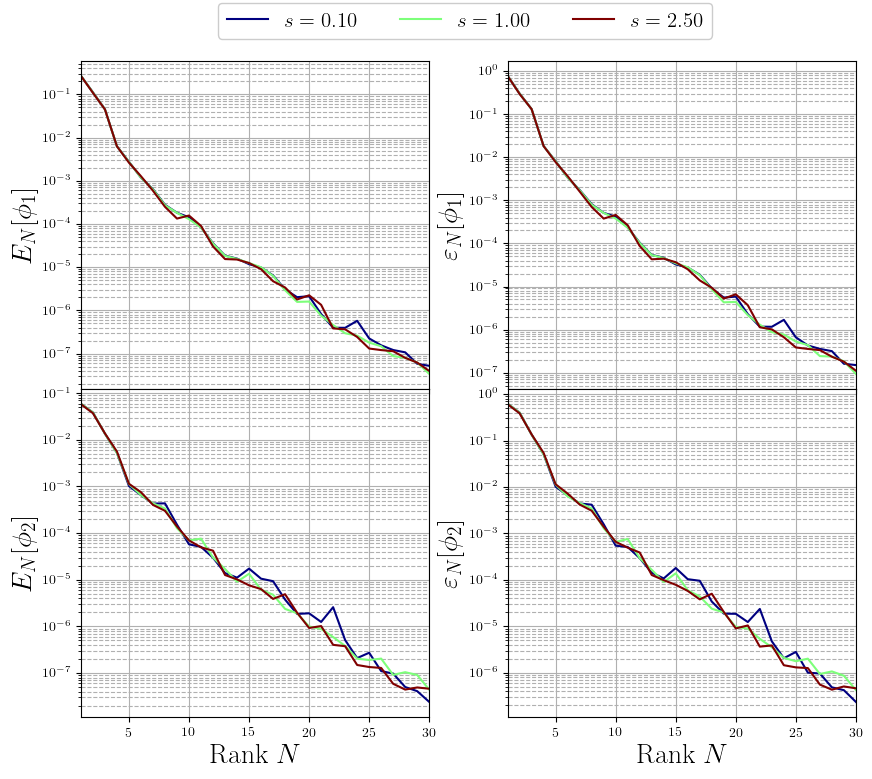

In [11]:
TrainingErrFig, axs = plt.subplots(nrows = len(var_names), ncols = 2, sharex = True, figsize = (10,8) )

Nmax = 30
M = np.arange(1,Nmax+1,1)

for ii in range(len(var_names)):
    
    colors = cm.jet(np.linspace(0,1,len(s)))
    for jj in range(len(s)):
        axs[ii, 0].semilogy(M, train_abs_err[:Nmax, ii, jj], c=colors[jj], label = r'$s={:.2f}'.format(s[jj])+'$')
        axs[ii, 1].semilogy(M, train_rel_err[:Nmax, ii, jj], c=colors[jj], label = r'$s={:.2f}'.format(s[jj])+'$')

    axs[ii, 0].set_xticks(np.arange(0,Nmax+1,5))
    axs[ii, 0].set_xlim(1,Nmax)
    axs[ii, 0].set_ylabel(r"$E_N["+tex_var_names[ii]+"]$",fontsize=20)
    axs[ii, 1].set_ylabel(r"$\varepsilon_N["+tex_var_names[ii]+"]$",fontsize=20)
    
axs[1, 0].set_xlabel(r"Rank $N$",fontsize=20)
axs[1, 1].set_xlabel(r"Rank $N$",fontsize=20)
    
for ax in axs.flatten():
    ax.grid(which='major',linestyle='-')
    ax.grid(which='minor',linestyle='--')

Line, Label = axs[0,0].get_legend_handles_labels()

TrainingErrFig.legend(Line, Label, fontsize=15, loc=(0.25,0.95), ncols = len(s), framealpha = 1)
TrainingErrFig.subplots_adjust(hspace = 0, wspace=0.225, top = 0.93)

## Calculation of the Lebesgue Constant
The Lebesgue Constant $\Lambda_N$ is important for the GEIM algorithm, since it appears in the *a-priori* error estimation for the reduction technique. The procedure on how this is computed was introduced in [Maday et al., (2015)](https://www.sciencedirect.com/science/article/pii/S0045782515000389?via%3Dihub).

In [23]:
from pyforce.offline.geim import computeLebesgue

Lebesgue_const = np.zeros((Mmax, len(var_names), len(s)))

bar = LoopProgress('Computing Lebesgue', final = len(var_names) * len(s))

for field_i in range(len(var_names)):
    for jj in range(len(s)):
        Lebesgue_const[:, field_i, jj] = computeLebesgue(geim_data[var_names[field_i]][jj].magic_fun,
                                                        geim_data[var_names[field_i]][jj].magic_sens)
        
        bar.update(1, percentage=False)

Computing Lebesgue: 6.000 / 6.00 - 8.692 s/it


Let us plot it to see the effect of the point spread

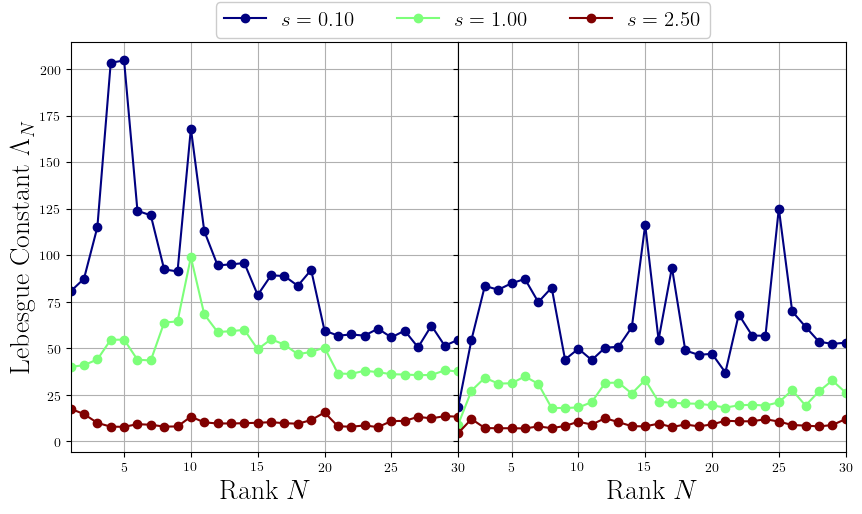

In [40]:
LebesgueFig, axs = plt.subplots(nrows = 1, ncols = 2, sharex = True, sharey = True, figsize = (10,5) )

for field_i in range(len(var_names)):
    colors = cm.jet(np.linspace(0,1,len(s)))
    for jj in range(len(s)):
        axs[field_i].plot(M, Lebesgue_const[:, field_i, jj], '-o', c=colors[jj], label = r'$s={:.2f}'.format(s[jj])+'$')

    axs[field_i].set_xlabel(r"Rank $N$",fontsize=20)
    axs[field_i].grid(which='major',linestyle='-')
    axs[field_i].grid(which='minor',linestyle='--')
    
    axs[field_i].set_xticks(np.arange(0,Nmax+1,5))
    axs[field_i].set_xlim(1,Nmax)
    
axs[0].set_ylabel(r"Lebesgue Constant $\Lambda_N$",fontsize=20)
for ax in axs.flatten():
    ax.grid(which='major',linestyle='-')
    ax.grid(which='minor',linestyle='--')
    
Line, Label = axs[0].get_legend_handles_labels()

LebesgueFig.legend(Line, Label, fontsize=15, loc=(0.25,0.925), ncols = len(s), framealpha = 1)
LebesgueFig.subplots_adjust(hspace = 0, wspace=0, top = 0.93)